
## Execute computer vision inference on large videos using managed queues, notifications, and automatic scaling with Amazon SageMaker Asynchronous Endpoints

### Table of Contents

* Background
* Setup
* Download and trigger pre-trained maskrcnn model on a sample image
* Create model archive and upload to S3
* Create SageMaker model with PyTorch inference container
* Real time hosted endpoint deployment and inference
* Create Asynchronous inference endpoints
* Invoke asynchronous endpoint
* Enable autoscaling
* Cleanup

### Background

AWS customers are increasingly using computer vision (CV) models on large input payloads that can take a few minutes of processing time. For example, space technology companies work with a stream of high resolution satellite imagery to detect particular objects of interest. Similarly, healthcare companies process high resolution biomedical images or videos like echocardiograms to detect anomalies. Also, media companies scan images and videos uploaded by their customers to ensure they are compliant and without copyright violations. These applications receive a burst of incoming traffic at different times in the day and require near real time processing with completion notifications at a low cost. 

In this notebook, we serve a PyTorch Computer Vision model with SageMaker asynchronous inference endpoints to process a burst of traffic of large input payload videos. We demonstrate the new capabilities of an internal queue with user defined concurrency and completion notifications. We configure autoscaling of instances including  scaling down to 0 when traffic subsides and scale back up as the request queue fills up. We use [SageMaker’s pre-built TorchServe container](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) with a custom inference script for preprocessing the videos before model invocation. 

   1. Large payload input of a high resolution video segment of 70 MB
   2. Large payload output from a PyTorch pre-trained mask-rcnn model 
   3. Large response time from the model of 30 seconds on a gpu instance
   4. Auto-queuing of inference requests with asynchronous inference
   5. Notifications of completed requests via SNS 
   6. Auto-scaling of endpoints based on queue length metric with minimum value set to 0

![Workflow](images/Async_Diagram.png)

### Setup


If you run this notebook in SageMaker Studio, you need to make sure ipywidgets is installed and restart the kernel, so please uncomment the code in the next cell, and run it.

In [1]:
# %%capture
# import IPython
# import sys

# !{sys.executable} -m pip install ipywidgets
# IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

In [2]:
!python -m pip install --upgrade pip --quiet
!pip install -U awscli --quiet
!pip install torch==1.8.0 --quiet 
!pip install torchvision==0.9.0 --quiet 
!pip install -U sagemaker --quiet

In [3]:
import torch
import torchvision
import torchvision.models as models
import sagemaker
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.pytorch import PyTorchModel
import boto3
import datetime
import time
from time import strftime,gmtime
import json
import os
import urllib
import sys
import io

role = get_execution_role()
boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
region = boto_session.region_name
bucket = sm_session.default_bucket()
prefix = 'async-inference-maskrcnn'

print(region)
print(role)
print(bucket)
print(prefix)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


us-east-1
arn:aws:iam::622343165275:role/service-role/AmazonSageMaker-ExecutionRole-20220208T115633
sagemaker-us-east-1-622343165275
async-inference-maskrcnn


In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.8.0
0.9.0


Specify your IAM role. Go the AWS IAM console (https://console.aws.amazon.com/iam/home) and add the following policies to your IAM Role:
* SageMakerFullAccessPolicy
* Amazon S3 access: Apply this to get and put objects in your Amazon S3 bucket. Replace `bucket_name` with the name of your Amazon S3 bucket:      

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:AbortMultipartUpload",
                "s3:ListBucket"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:s3:::bucket_name/*"
        }
    ]
}
```

* (Optional) Amazon SNS access: Add `sns:Publish` on the topics you define. Apply this if you plan to use Amazon SNS to receive notifications.

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "sns:Publish"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:sns:us-east-2:123456789012:MyTopic"
        }
    ]
}
```

* (Optional) KMS decrypt, encrypt if your Amazon S3 bucket is encrypte.

### Download and trigger maskrcnn model on a sample image

Using pre-trained maskrcnn resnet 50 model

In [82]:
import torch
import torchvision.models as models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [83]:
# -- downloads from hugging face a -- pytorch model
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
from PIL import Image
import torchvision.transforms as transforms

img = io.BytesIO(open('images/birds.jpg', 'rb').read())
birds_image = Image.open(img).convert('RGB')
birds_image = transforms.ToTensor()(birds_image)
print(type(birds_image))

<class 'torch.Tensor'>


In [84]:
model.eval()
outputs = model([birds_image])
output = outputs[0]

In [85]:
#Print output
res = []
for output in outputs:
    res.append({'boxes':output['boxes'].detach().numpy().tolist(),'labels':output['labels'].detach().numpy().tolist(),'scores':output['scores'].detach().numpy().tolist()})
print(json.dumps(res))

[{"boxes": [[33.49818420410156, 284.2646179199219, 1048.5108642578125, 810.3135986328125], [1107.794677734375, 256.5046081542969, 1977.7801513671875, 898.3372802734375], [880.5606079101562, 677.7882690429688, 1897.28515625, 1180.1151123046875], [836.5274047851562, 260.9998474121094, 2045.798828125, 1182.13671875], [20.251750946044922, 508.69610595703125, 678.1981811523438, 850.190673828125], [966.52587890625, 446.9561767578125, 1870.8499755859375, 991.31005859375], [895.2606811523438, 830.11376953125, 1660.05810546875, 965.4442749023438], [23.06002426147461, 543.3861083984375, 359.94970703125, 823.0071411132812], [892.9069213867188, 859.9248657226562, 1554.46337890625, 1094.5997314453125], [411.6666259765625, 565.1069946289062, 526.0043334960938, 700.0460815429688], [170.635498046875, 251.1158447265625, 1672.892333984375, 898.518310546875]], "labels": [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], "scores": [0.9990274906158447, 0.9958305954933167, 0.991154670715332, 0.8519430756568909, 

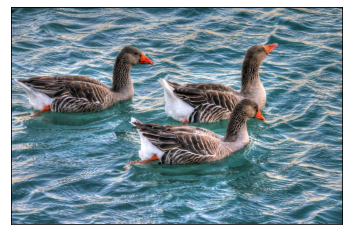

In [10]:
#Print original image
from torchvision.utils import make_grid
grid = make_grid([birds_image])
show(grid)

Print original image with model output boxes

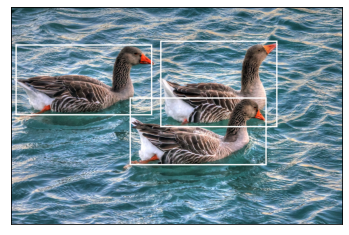

In [86]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
score_threshold = .9
birds_with_boxes = [
    draw_bounding_boxes(read_image('images/birds.jpg'), boxes=output['boxes'][output['scores'] > score_threshold], width=10)
]
show(birds_with_boxes)

### Create model archive and upload to S3

In [16]:
!mkdir -p model_and_code
!mkdir -p model_and_code/code

In [19]:
torch.save(model, 'model_and_code/model.pth')
!mkdir -p model_and_code/code
#!cp ./code/* model_and_code/code
#!tar cvzf model.tar.gz -C model_and_code/ . 

In [20]:
%%writefile model_and_code/code/inference.py
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import io
import json
import logging
import os
import tempfile

import cv2
import torch
import torchvision.transforms as transforms

# This code will be loaded on each worker separately..
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


def model_fn(model_dir):
    device = get_device()
    logger.info(">>> Device is '%s'.." % device)
    model = torch.load(model_dir + '/model.pth', map_location=torch.device(device))
    print(type(model))
    logger.info(">>> Model loaded!..")
    return model

def transform_fn(model, request_body, content_type, accept):
    interval = int(os.environ.get('FRAME_INTERVAL', 30))
    frame_width = int(os.environ.get('FRAME_WIDTH', 1024))
    frame_height = int(os.environ.get('FRAME_HEIGHT', 1024))
    batch_size = int(os.environ.get('BATCH_SIZE', 24))

    f = io.BytesIO(request_body)
    tfile = tempfile.NamedTemporaryFile(delete=False)
    tfile.write(f.read())

    all_predictions = []

    for batch_frames in batch_generator(tfile, frame_width, frame_height, interval, batch_size):
        batch_inputs = preprocess(batch_frames)  # returns 4D tensor
        batch_outputs = predict(batch_inputs, model)
        logger.info(">>> Length of batch predictions: %d" % len(batch_outputs))
        batch_predictions = postprocess(batch_outputs)
        all_predictions.extend(batch_predictions)
    
    logger.info(">>> Length of final predictions: %d" % len(all_predictions))
    return json.dumps(all_predictions)

def preprocess(inputs, preprocessor=transforms.ToTensor()):
    outputs = torch.stack([preprocessor(frame) for frame in inputs])
    return outputs
    
def predict(inputs, model):
    logger.info(">>> Invoking model!..")

    with torch.no_grad():
        device = get_device()
        model = model.to(device)
        input_data = inputs.to(device)
        model.eval()
        outputs = model(input_data)

    return outputs

def postprocess(inputs):
    outputs = []
    for inp in inputs:
        outputs.append({
            'boxes': inp['boxes'].detach().cpu().numpy().tolist(),
            'labels': inp['labels'].detach().cpu().numpy().tolist(),
            'scores': inp['scores'].detach().cpu().numpy().tolist()
        })
    return outputs

def get_device():
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    return device

def batch_generator(tfile, frame_width, frame_height, interval, batch_size):
    cap = cv2.VideoCapture(tfile.name)
    frame_index = 0
    frame_buffer = []

    while cap.isOpened():

        success, frame = cap.read()

        if not success:
            cap.release()
            if frame_buffer:
                yield frame_buffer
            return

        if frame_index % interval == 0:
            frame_resized = cv2.resize(frame, (frame_width, frame_height), interpolation=cv2.INTER_AREA)
            frame_buffer.append(frame_resized)

        if len(frame_buffer) == batch_size:
            yield frame_buffer
            frame_buffer.clear()

        frame_index += 1
    else:
        raise Exception("Failed to open video '%s'!.." % tfile.name)



Writing model_and_code/code/inference.py


In [21]:
!tar cvzf model.tar.gz -C model_and_code/ . 

./
./code/
./code/inference.py
./.ipynb_checkpoints/
./model.pth


In [22]:
from sagemaker.s3 import S3Uploader
file_key = 'model.tar.gz'
model_artifact = S3Uploader.upload(file_key,'s3://{}/{}/model'.format(bucket, prefix))
print(model_artifact)

s3://sagemaker-us-east-1-622343165275/async-inference-maskrcnn/model/model.tar.gz


### Create SageMaker model with PyTorch inference container

In [23]:
from sagemaker.image_uris import retrieve

deploy_instance_type = 'ml.g4dn.xlarge'
pytorch_inference_image_uri = retrieve('pytorch',
                                       region,
                                       version='1.7.1',
                                       py_version='py3',
                                       instance_type = deploy_instance_type,
                                       accelerator_type=None,
                                       image_scope='inference')
print(pytorch_inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.7.1-gpu-py3


In [25]:
from sagemaker.utils import name_from_base

model_name = name_from_base(f"maskrcnn-resnet")
print(model_name)

maskrcnn-resnet-2022-12-20-17-59-14-783


In [26]:
container = pytorch_inference_image_uri
print(container)
print(model_name)

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.7.1-gpu-py3
maskrcnn-resnet-2022-12-20-17-59-14-783


### Real time hosted endpoint deployment and inference

Create an endpoint config name. Here we create one based on the date so it we can search endpoints based on creation time.

In [27]:
print(model_name)
#endpoint_config_name = f"maskrcnnEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=model_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ]
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

maskrcnn-resnet-2022-12-20-17-59-14-783
Created EndpointConfig: arn:aws:sagemaker:us-east-1:622343165275:endpoint-config/maskrcnn-resnet-2022-12-20-17-59-14-783


In [29]:
#endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
response = sm_client.create_endpoint(
    EndpointName=model_name,
    EndpointConfigName=model_name
)

In [31]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=model_name)
resp = sm_client.describe_endpoint(EndpointName=model_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


In [33]:
ep= model_name
feed_data = open('images/birds.jpg', 'rb')
sm_runtime = boto3.Session().client('sagemaker-runtime')
r = sm_runtime.invoke_endpoint(EndpointName=ep, Body=feed_data)

In [34]:
print(r['Body'].read())

b'[{"boxes": [[31.00066375732422, 185.1052703857422, 433.9681091308594, 501.9935302734375], [346.3128967285156, 410.75592041015625, 789.4537963867188, 749.7699584960938], [360.08319091796875, 139.71994018554688, 834.5388793945312, 699.4168701171875], [445.6692199707031, 325.65277099609375, 718.961181640625, 566.6964111328125], [466.4849853515625, 166.37548828125, 797.0263061523438, 537.3280639648438], [484.1777648925781, 443.4866943359375, 708.4545288085938, 721.5338134765625], [14.377577781677246, 314.89288330078125, 362.8853454589844, 531.799072265625], [126.4969482421875, 429.94671630859375, 793.076416015625, 846.5239868164062], [95.3680419921875, 166.49591064453125, 635.573486328125, 595.076171875], [21.680585861206055, 200.88897705078125, 458.9969787597656, 774.1900634765625]], "labels": [16, 16, 16, 16, 16, 16, 16, 16, 16, 16], "scores": [0.9995611310005188, 0.9974155426025391, 0.9939456582069397, 0.22476854920387268, 0.1833336502313614, 0.12950502336025238, 0.11609508097171783, 

### Create Asynchronous inference endpoints

Unlike real time hosted endpoints, asynchronous endpoints support scaling
down instances to 0 by setting the minimum capacity to 0. With this feature, we can scale
down to 0 instances when there is no traffic and pay only when the payloads arrive. Let's create an asynchronous endpoint to see it in action below -

In [35]:
bucket_prefix = "async-inference-blog"
resource_name = "AsyncInferenceDemo-SNS"

Create Error and Success SNS topics

In [37]:
response = sns_client.create_topic(Name="Async-Demo-ErrorTopic")
error_topic= response['TopicArn']
print(error_topic)

arn:aws:sns:us-east-1:622343165275:Async-Demo-ErrorTopic


In [38]:
response = sns_client.create_topic(Name="Async-Demo-SuccessTopic")
success_topic = response['TopicArn']
print(success_topic)

arn:aws:sns:us-east-1:622343165275:Async-Demo-SuccessTopic


List SNS topics

In [39]:
response = sns_client.list_topics()
topics = response["Topics"]
print(topics)

[{'TopicArn': 'arn:aws:sns:us-east-1:622343165275:Async-Demo-ErrorTopic'}, {'TopicArn': 'arn:aws:sns:us-east-1:622343165275:Async-Demo-SuccessTopic'}, {'TopicArn': 'arn:aws:sns:us-east-1:622343165275:LLM_Default_CloudWatch_Alarms_Topic'}]


Optionally Subscribe to an SNS topic

In [ ]:
#Note: Replace with your email id

# email_id = 'your-email@domain-name.com'
# email_sub_1 = sns_client.subscribe(
#     TopicArn=success_topic,
#     Protocol='email',
#     Endpoint=email_id)

# email_sub_2 = sns_client.subscribe(
#     TopicArn=error_topic,
#     Protocol='email',
#     Endpoint=email_id)

#Note: You will need to confirm by clicking on the email you recieve to complete the subscription

In [40]:
from sagemaker.utils import name_from_base

model_name_async = name_from_base(f"maskrcnn-async")
print(model_name_async)

maskrcnn-async-2022-12-20-18-22-07-597


Create an endpoint config name. Here we create one based on the date so it we can search endpoints based on creation time.

In [41]:
print(model_name_async)
#endpoint_config_name = f"PyTorchAsyncEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=model_name_async,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{bucket_prefix}/output",
            #  Optionally specify Amazon SNS topics
            "NotificationConfig": {
              "SuccessTopic": success_topic,
              "ErrorTopic": error_topic,
            }
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 2
        }
    }
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

maskrcnn-async-2022-12-20-18-22-07-597
Created EndpointConfig: arn:aws:sagemaker:us-east-1:622343165275:endpoint-config/maskrcnn-async-2022-12-20-18-22-07-597


In [42]:
#endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"

create_endpoint_response = sm_client.create_endpoint(EndpointName=model_name_async, EndpointConfigName=model_name_async)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

Creating Endpoint: arn:aws:sagemaker:us-east-1:622343165275:endpoint/maskrcnn-async-2022-12-20-18-22-07-597


In [45]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=model_name_async)
resp = sm_client.describe_endpoint(EndpointName=model_name_async)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


### Upload input video file

In [46]:
def upload_file(input_location):
    prefix = f"{bucket_prefix}/input"
    return sm_session.upload_data(
        input_location, 
        bucket=sm_session.default_bucket(),
        key_prefix=prefix, 
        extra_args={"ContentType": "video/mp4"})

In [47]:
input_1_location = "videos/ducks.mp4"
input_1_s3_location = upload_file(input_1_location)

In [48]:
print(input_1_s3_location)

s3://sagemaker-us-east-1-622343165275/async-inference-blog/input/ducks.mp4


In [50]:
print(model_name_async)

maskrcnn-async-2022-12-20-18-22-07-597


### Invoke asynchronous endpoint

In [51]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=model_name_async, 
    InputLocation=input_1_s3_location)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

OutputLocation: s3://sagemaker-us-east-1-622343165275/async-inference-blog/output/5421741f-ecb1-4dde-aae4-1b1ba768626c.out


In [52]:
from botocore.exceptions import ClientError

def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sm_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                print("waiting for output...")
                time.sleep(2)
                continue
            raise


In [76]:
%%time
output = get_output(output_location)
print(f"Output size in bytes: {((sys.getsizeof(output)))}")

Output size in bytes: 54916
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 166 ms


In [71]:
input_1_s3_location

's3://sagemaker-us-east-1-622343165275/async-inference-blog/input/ducks.mp4'

### Trigger 10 asynchronous requests on a single instance 

In [55]:
inferences = []
for i in range(1,10):
    start = time.time()
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=model_name_async, 
    InputLocation=input_1_s3_location)
    output_location = response["OutputLocation"]
    inferences += [(input_1_s3_location, output_location)]
    time.sleep(0.5)
print("\Async invocations for Pytorch serving default: \n")

for input_file, output_location in inferences:
    output = get_output(output_location)
    print(f"Input File: {input_file}, Output location: {output_location}")

\Async invocations for Pytorch serving default: 

waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
Input File: s3://sagemaker-us-east-1-622343165275/async-inference-blog/input/ducks.mp4, Output location: s3://sagemaker-us-east-1-622343165275/async-inference-blog/output/ade0eba1-6c98-4c47-a7e3-b1f1a2862282.out
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
Input File: s3://sagemaker-us-east-1-622343165275/async-inference-blog/input/ducks.mp4, Output location: s3://sagemaker-us-east-1-622343165275/async-inference-blog/output/bd603fda-20be-4b85-8830-20386a5e5f7a.out
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output..

### Enable autoscaling

In [80]:
client = boto3.client('application-autoscaling') # Common class representing Application Auto Scaling for SageMaker amongst other services

resource_id='endpoint/' + model_name_async + '/variant/' + 'variant1' # This is the format in which application autoscaling references the endpoint

response = client.register_scalable_target(
    ServiceNamespace='sagemaker', 
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=0,  
    MaxCapacity=5
)

response = client.put_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
    PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 5.0, # The target value for the metric. 
        'CustomizedMetricSpecification': {
            'MetricName': 'ApproximateBacklogSizePerInstance',
            'Namespace': 'AWS/SageMaker',
            'Dimensions': [
                {'Name': 'EndpointName', 'Value': endpoint_name }
            ],
            'Statistic': 'Average',
        },
        'ScaleInCooldown': 1200, # The cooldown period helps you prevent your Auto Scaling group from launching or terminating 
                                # additional instances before the effects of previous activities are visible. 
                                # You can configure the length of time based on your instance startup time or other application needs.
                                # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start. 
        'ScaleOutCooldown': 12 # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled. 
                            # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    }
)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [81]:
print(response)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:622343165275:scalingPolicy:76b6c891-bb24-466c-b19e-acc5270f0696:resource/sagemaker/endpoint/maskrcnn-async-2022-12-20-18-22-07-597/variant/variant1:policyName/Invocations-ScalingPolicy', 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/maskrcnn-async-2022-12-20-18-22-07-597/variant/variant1-AlarmHigh-637fe7d8-1ed5-44ec-8bb9-6c5f338ac4b8', 'AlarmARN': 'arn:aws:cloudwatch:us-east-1:622343165275:alarm:TargetTracking-endpoint/maskrcnn-async-2022-12-20-18-22-07-597/variant/variant1-AlarmHigh-637fe7d8-1ed5-44ec-8bb9-6c5f338ac4b8'}, {'AlarmName': 'TargetTracking-endpoint/maskrcnn-async-2022-12-20-18-22-07-597/variant/variant1-AlarmLow-16aad0e4-dfe0-4237-8f1e-4733873b6262', 'AlarmARN': 'arn:aws:cloudwatch:us-east-1:622343165275:alarm:TargetTracking-endpoint/maskrcnn-async-2022-12-20-18-22-07-597/variant/variant1-AlarmLow-16aad0e4-dfe0-4237-8f1e-4733873b6262'}], 'ResponseMetadata': {'RequestId': '9b495560-24e1-4926-a0ff-3cdc6a5ec84e', 'HTTPStatusCod

In [79]:
client.delete_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
)

{'ResponseMetadata': {'RequestId': 'bbdd95b9-afac-45ac-83af-3076b5ed72eb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bbdd95b9-afac-45ac-83af-3076b5ed72eb',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Wed, 21 Dec 2022 20:12:30 GMT'},
  'RetryAttempts': 0}}

### Trigger 1000 asynchronous invocations with autoscaling from 1 to 5 and then scale down to 0 on completion

Optionally [delete the SNS topic](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/sns.html#SNS.Client.delete_topic) to avoid flooding of notifications on 1000 invocations below 

In [67]:
print(endpoint_name)
for i in range(1,1000):
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=model_name_async, 
    InputLocation=input_1_s3_location)
print("\Async invocations for Pytorch serving with auotscaling \n")

sm-2022-12-20-18-23-00
\Async invocations for Pytorch serving with auotscaling 



Plot graphs from CloudWatch Metrics

In [63]:
import pandas as pd
cw = boto3.Session().client("cloudwatch")

In [73]:
import datetime
from datetime import datetime,timedelta
def get_sagemaker_metrics(endpoint_name,
                          endpoint_config_name,
                          variant_name,
                          metric_name,
                          statistic,
                          start_time,
                          end_time):
    dimensions = [
        {
            "Name": "EndpointName",
            "Value": endpoint_name
        },
        {
            "Name": "VariantName",
            "Value": variant_name
        }
    ]
    if endpoint_config_name is not None:
        dimensions.append({
            "Name": "EndpointConfigName",
            "Value": endpoint_config_name
        })
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions
    )
    rename = endpoint_config_name if endpoint_config_name is not None else 'ALL'
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop(["Unit"], axis=1)\
            .rename(columns={statistic: rename})

def plot_endpoint_model_latency_metrics(endpoint_name, endpoint_config_name, variant_name, start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metric_name = "ModelLatency"
    statistic = "Average"
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name, 
        statistic,
        start_time,
        end_time)
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

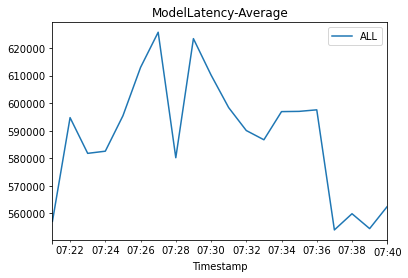

In [74]:
model_latency_metrics = plot_endpoint_model_latency_metrics(model_name_async , None, "variant1")

Similarly, we plot other Cloud Watch Metrics associated with the Endpoint as shown below

### Cloud watch metrics - Approximate Backlog Size and Approximate Backlog Size per instance 
The backlog grows from 0 to 1000 when the burst of traffic is invoked. Then, the endpoint autoscales every 120 seconds upto the max number of instances = 5. The Backlog size per instance changes rapidly during autoscaling. At max number of instances, the queue backlog reduces at about 18 invocation per minute and finally reaches 0. 

![title](images/backlog_size_metrics.png)

The number of invocations successfully processed are about 18 invocations per minute

![title](images/invocations_metrics.png)

The model latency for 2 concurrent invocations is approximately 30 seconds 

![title](images/model_latency_metrics.png)

The instances autoscale down to 0 once the queue size goes down to 0

![title](images/instance_count_0.png)

### Cleanup

If you enabled auto-scaling for your endpoint, ensure you deregister the endpoint as a scalable target before deleting the endpoint. To do this, please uncomment the cell below and run :

In [ ]:
# response = client.deregister_scalable_target(
#     ServiceNamespace='sagemaker',
#     ResourceId='resource_id',
#     ScalableDimension='sagemaker:variant:DesiredInstanceCount'
# )

Endpoints should be deleted when no longer in use, since (per the [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/)) they're billed by time deployed

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

You may also want to delete any other resources you might have created such as SNS topics, S3 objects, etc.